# Tarea 2: Backpropagation, descenso de gradiente y entrenamiento <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Guillermo Martínez
Fecha de entrega: 16 de octubre de 2020

Para la **corrección automática** hemos creado una funcionalidad nueva que les permite comprobar el tiempo que demora su solución. En colab estos tiempos pueden ser variables entre una ejecución y otra del mismo código. No se preocupen si les falla el test por `time` algunas veces. Pueden hacer `time=0` en la ultima linea de cada test para evitar estos errores. También hemos usado nombres para los tests. Estos pueden serles de ayuda para determinar qué partes de su implementación deben corregir ;-)


In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-s_s3k16d/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-s_s3k16d/cc6204
  Created wheel for cc6204: filename=cc6204-0.3.2-cp36-none-any.whl size=4708 sha256=af8fc1d1714573652cb9e0e54045154d28033b9dd33dd71e065826af36e04b3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-4c7fsvlu/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
  Found existing installation: cc6204 0.3.2
    Uninstalling cc6204-0.3.2:
      Successfully uninstalled cc6204-0.3.2


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Preliminares: funciones de activación y función de error


## 1a) Derivando las funciones de activación

Escribe acá tus respuestas para las derivadas de cada función de activación.
<br>

\begin{equation}
\frac{\partial\ \text{relu}(x)}{\partial x} = \begin{cases}
      1 & \text{if}\ x > 0 \\
      0 & \text{if}\ x < 0
    \end{cases} \\ \\ 
\end{equation}
<br>
<br>


\begin{eqnarray}
\frac{\partial\ \text{swish}(x, \beta)}{\partial x} & = & \frac{\partial\ x \cdot \sigma(\beta x)}{\partial x} \\
& = & (1 - e^{\beta x})^{-1} + x \cdot \frac{\partial\ (1 - e^{\beta x})^{-1}}{\partial x} \\
& = & \sigma(\beta x) + \beta x\ \sigma(\beta x) \cdot \frac{1}{1+ e^{-\beta x}} \cdot e^{-\beta x} \\
& = & \beta x\ \cdot \sigma(\beta x) + \sigma(\beta x)(1 - \beta x \cdot \sigma(\beta x)) \\
& = & \boxed{\beta\ \text{swish}(x, \beta) + \text{sigmoid}(\beta x)(1 - \beta\ \text{swish}(x, \beta)) }
\\
\\
\frac{\partial\ \text{swish}(x, \beta)}{\partial \beta} & = & \frac{\partial\ x \cdot \sigma(\beta x)}{\partial \beta} \\
& = & x \cdot \frac{\partial\ (1 + e^{-\beta x})^{-1}}{\partial \beta} \\
& = & x^2 \sigma(\beta x) \cdot \frac{1}{1 + e^{-\beta x}} \cdot e^{-\beta x} \\
& = & x \cdot \sigma(\beta x) \cdot (x - x \cdot \sigma(\beta x)) \\
& = & \boxed{\text{swish}(x, \beta) \cdot (x - \text{swish}(x, \beta))}
\end{eqnarray}
<br>
<br>

\begin{eqnarray}
\frac{\partial\ \text{celu}(x, \alpha)}{\partial x} & = & \begin{cases}
      1 & \text{if}\ x \geq 0 \\
      \text{exp}(\frac{x}{\alpha}) & \text{otherwise}
    \end{cases} \\
\\
\frac{\partial\ \text{celu}(x, \alpha)}{\partial \alpha} & = & \begin{cases}
      0 & \text{if}\ x \geq 0 \\
      \text{exp}(\frac{x}{\alpha})(1 - \frac{x}{\alpha}) - 1 & \text{otherwise}
    \end{cases}\\
\end{eqnarray}}

In [ ]:
# Más adelante en la tarea necesitaremos usar las funciones de activación 
# que implementaste en la Tarea 1 y sus derivadas.
# Acá implementa las derivadas de las funciones de activación

# Una forma de implementarlas (tal vez no la mejor) es reutilizando la misma función
def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

def relu(T, gradient=False):
  outT = torch.clone(T)
  if gradient:
    outT[T <= 0] = 0
    outT[T > 0] = 1
    return outT
  outT[T < 0] = 0
  return outT

def swish(T, beta=1, gradient=False):
  if gradient:
    swishT = swish(T, beta)
    sigT = sig(beta * T)
    gradient_tensor = beta * swishT + sigT * (1 - beta * swishT)
    gradient_beta = swishT * (x - swishT)
    return gradient_tensor, gradient_beta
  return T * sig(beta * T)

def celu(T, alpha=1, gradient=False):
  if alpha == 0:
    raise ValueError("alpha cannot be 0")
  if gradient:
    gradient_tensor = T.clone()
    gradient_alpha = T.clone()
    gradient_tensor[T >= 0] = 1
    gradient_tensor[T < 0] = torch.exp((gradient_tensor[T < 0] / alpha))
    gradient_alpha[T >= 0] = 0
    gradient_alpha[T < 0] = torch.exp((gradient_alpha[T < 0] / alpha)) * (1 - gradient_alpha[T < 0] / alpha) - 1
    return gradient_tensor, gradient_alpha
  outT = T.clone()
  outT[T < 0] = alpha * (outT[T<0] / alpha).expm1()
  return outT

def tanh(T, gradient=False):
  if gradient:
    return 1 - tanh(T).pow(2)
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)
  
def softmax(T, dim=1):
  t = T
  t = t - torch.unsqueeze(torch.max(t, dim)[0], dim)
  t = torch.exp(t)
  dim_sum = torch.unsqueeze(torch.sum(t, dim=dim), dim)
  res = t / dim_sum
  return res



## 1b) Entropía Cruzada

In [ ]:
# Tu código acá
def CELoss(Q, P, estable=True, epsilon=1e-8):
  # Q y P: representan distribuciones de probabilidad discreta  
  #        (mediante matrices con las mismas dimensiones)
  # estable y epsilon: nos permiten lograr estabilidad numérica cuando 
  #       intentamos computar el logaritmo de valores muy pequeños.
  #       epsilon limitará el valor mínimo del valor original cuando estable=True
  if estable:
    Q_estable = Q.clone()
    Q_estable[Q <= epsilon] = epsilon
    ce_loss_estable = torch.mean(-torch.sum(P * torch.log(Q_estable), 1), 0)
    return ce_loss_estable
  ce_loss = torch.mean(-torch.sum(P * torch.log(Q), 1), 0)
  return ce_loss

In [ ]:
# Tests del API del curso
for test in ['small', 'estable', 'eps', 'no-estable']:
  # Obtengamos dos distribuciones de probabilidad y los parametros estable y epsilon
  Q, P, estable, eps = corrector.get_test_data(homework=2, question="1b", test=test, token=token)
  # Corramos tu implementacion de CELoss para ver como se comporta
  s = timer()
  result = CELoss(Q=torch.Tensor(Q), P=torch.Tensor(P), estable=estable, epsilon=eps)
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="1b", test=test, token=token, answer=result, time=t)

Correct Test!
Correct Test!
Correct Test!
Correct Test!


## 1c) Opcional: Entropía Cruzada Categórica

In [ ]:
# No es necesario que entregues código en esta parte.
# Pero si quieres, igual hay espacio ;-)

# Parte 2: Más derivadas y back propagation

## 2a) Derivando la última capa

Escribe tu cálculo acá.
<br>

\begin{eqnarray}
\frac{\partial \cal L}{\partial u^{(L+1)}} & = & \frac{\partial (-\frac{1}{N}\sum\limits_{j=1}^N y_{j}\log(\hat{y_{j}}) )}{\partial u_{i}^{(L+1)}} \\
& = & -\frac{1}{N} ( \sum\limits_{j=1}^N y_{j} \frac{\partial \log(\hat{y_{j}})}{\partial u_{i}^{(L+1)}} ) \\
& = & -\frac{1}{N} ( \sum\limits_{j=1}^N y_{j} \frac{1}{\hat{y_{j}}} \frac{\partial \hat{y_{j}}}{\partial u_{i}^{(L+1)}} ) \\
\end{eqnarray}
<br>

Analizando la derivada parcial de la sumatoria se obtiene lo siguiente:
<br>

\begin{eqnarray}
\frac{\partial\ \hat{y_{j}}}{\partial u_{i}^{(L+1)}} & = & \frac{\partial\ \text{softmax}(u_{j}^{(L+1)})}{\partial u_{i}^{(L+1)}} \\
& = & \frac{\partial \frac{e^{u_{j}}}{\sum\limits_{k=1}^N e^{u_{k}}}}{\partial u_{i}^{(L+1)}} \\
\end{eqnarray}
<br>

aquí se dan dos casos; primero, el caso en que $i = j$:
<br>

\begin{eqnarray}
\frac{\partial \frac{e^{u_{i}}}{\sum\limits_{k=1}^N e^{u_{k}}}}{\partial u_{i}^{(L+1)}} & = & \frac{e^{u_{i}} \sum\limits_{k=1}^N e^{u_{k}} - e^{u_{i}}e^{u_{i}}}{(\sum\limits_{k=1}^N e^{u_{k}})^2}\\
& = & \frac{e^{u_{i}} (\sum\limits_{k=1}^N e^{u_{k}} - e^{u_{i}})}{(\sum\limits_{k=1}^N e^{u_{k}})^2} \\
& = & \frac{e^{u_{i}}}{\sum\limits_{k=1}^N e^{u_{k}}}\frac{(\sum\limits_{k=1}^N e^{u_{k}} - e^{u_{i}})}{\sum\limits_{k=1}^N e^{u_{k}}} \\
& = & \text{softmax}(u_{i})(1 - \text{softmax}(u_{i})) \\
& = & \hat{y_{i}}(1 - \hat{y_{i}}) \\
\end{eqnarray}
<br>

Por otro lado, para el caso en que $i \neq j$:
<br>

\begin{eqnarray}
\frac{\partial \frac{e^{u_{j}}}{\sum\limits_{k=1}^N e^{u_{k}}}}{\partial u_{i}^{(L+1)}} & = & \frac{0 - e^{u_{i}}e^{u_{j}}}{(\sum\limits_{k=1}^N e^{u_{k}})^2}\\
& = & - \frac{e^{u_{i}}}{\sum\limits_{k=1}^N e^{u_{k}}}\frac{e^{u_{j}}}{\sum\limits_{k=1}^N e^{u_{k}}} \\
& = & - \text{softmax}(u_{i})\text{softmax}(u_{j}) \\
& = & - \hat{y_{i}}\hat{y_{j}} \\
\end{eqnarray}
<br>

Con estos resultados podemos continuar lo que se realizó al principio:
<br>

\begin{eqnarray}
\frac{\partial \cal L}{\partial u^{(L+1)}} & = & -\frac{1}{N} ( \sum\limits_{j=1}^N y_{j} \frac{1}{\hat{y_{j}}} \frac{\partial \hat{y_{j}}}{\partial u_{i}^{(L+1)}} ) \\
& = & -\frac{1}{N} (\frac{y_{i}}{\hat{y_{i}}}\frac{\partial \hat{y_{i}}}{\partial u_{i}^{(L+1)}} + \sum\limits_{j \neq i}^N \frac{y_{j}}{\hat{y_{j}}} \frac{\partial \hat{y_{j}}}{\partial u_{i}^{(L+1)}} ) \\
& = & -\frac{1}{N} (\frac{y_{i}}{\hat{y_{i}}}\hat{y_{i}}(1 - \hat{y_{i}}) + \sum\limits_{j \neq i}^N \frac{y_{j}}{\hat{y_{j}}} (-\hat{y_{i}}\hat{y_{j}}) ) \\
& = & -\frac{1}{N} (y_{i} - y_{i}\hat{y_{i}} - \sum\limits_{j \neq i}^N y_{j}\hat{y_{i}} ) \\
& = & -\frac{1}{N} (y_{i} - \sum\limits_{j = 1}^N y_{j}\hat{y_{i}} ) \\
& = & -\frac{1}{N} (y_{i} - \hat{y_{i}}\sum\limits_{j = 1}^N y_{j} ) \\
& = & \boxed{\frac{1}{N} (\hat{y_{i}} - y_{i})} \\
\end{eqnarray}
<br>

## 2b) Derivando la última capa (continuación)

Escribe tus respuestas acá.
<br>

\begin{eqnarray}
\frac{\partial\cal L}{\partial U} & \implies & \frac{\partial \cal L}{\partial U_{i}} = \frac{\partial \cal L}{\partial u^{(L+1)}_{j}} \frac{\partial u^{(L+1)}_{j}}{\partial U_{i}} \\
& \implies & \frac{\partial u^{(L+1)}_{j}}{\partial U_{i}} = \frac{\partial (h^{(L)}_{jk}U_{k} + c)}{\partial U_{i}} \\
& = & \frac{\partial (h^{(L)}_{ji}U_{i} + c)}{\partial U_{i}} = h^{(L)}_{ji}\\
& \implies & \frac{\partial \cal L}{\partial U_{i}} = \frac{\partial \cal L}{\partial u^{(L+1)}_{j}} \cdot h^{(L)}_{ji} \\
& \implies & \boxed{\frac{\partial\cal L}{\partial U} = (h^{(L)})^{T} \cdot \frac{\partial \cal L}{\partial u^{(L+1)}}}
\end{eqnarray}
<br>

\begin{eqnarray}
\frac{\partial\cal L}{\partial c} & = & \frac{\partial \cal L}{\partial u^{(L+1)}_{i}} \frac{\partial u^{(L+1)}_{i}}{\partial c} = \frac{\partial \cal L}{\partial u^{(L+1)}_{i}} \frac{\partial (h^{(L)}_{ik}U_{k} + c)}{\partial c} \\
& = & \frac{\partial \cal L}{\partial u^{(L+1)}_{i}} \cdot {\textit{1}}_{i} = \text{sum}(\frac{\partial \cal L}{\partial u^{(L+1)}})\\
& \implies & \boxed{\frac{\partial\cal L}{\partial c} = \text{sum}(\frac{\partial \cal L}{\partial u^{(L+1)}})}
\end{eqnarray}
<br>

\begin{eqnarray}
\frac{\partial\cal L}{\partial h^{(L)}} & \implies & \frac{\partial\cal L}{\partial h^{(L)}_{ij}} = \frac{\partial \cal L}{\partial u^{(L+1)}_{k}} \frac{\partial u^{(L+1)}_{k}}{\partial h^{(L)}_{ij}} \\
& = & \frac{\partial \cal L}{\partial (h^{(L)}_{kl}U_{l} + c)} \frac{\partial (h^{(L)}_{kl}U_{l} + c)}{\partial h^{(L)}_{ij}} \\
& = & \frac{\partial \cal L}{\partial (h^{(L)}_{ij}U_{l} + c)} \frac{\partial (h^{(L)}_{ij}U_{j} + c)}{\partial h^{(L)}_{ij}}\\
& = &  \frac{\partial \cal L}{\partial u^{(L+1)}_{i}} \frac{\partial u^{(L+1)}_{i}}{\partial h^{(L)}_{ij}} = \frac{\partial \cal L}{\partial u^{(L+1)}_{i}}\cdot U_{j} \\
& \implies & \boxed{\frac{\partial\cal L}{\partial h^{(L)}} = \frac{\partial \cal L}{\partial u^{(L+1)}} \otimes U}
\end{eqnarray}
<br>

## 2c) Derivando desde las capas escondidas

Escribe tus respuestas acá. Repite los siguientes cálculos para $\text{relu}, \text{celu}, \text{swish}$
<br>

\begin{eqnarray}
\frac{\partial\cal L}{\partial u^{(k)}} & \implies & \frac{\partial \cal L}{\partial u^{(k)}_{ij}} = \frac{\partial \cal L}{\partial h^{(k)}_{kl}} \frac{\partial h^{(k)}_{kl}}{\partial u^{(k)}_{ij}} \\
& = & \frac{\partial \cal L}{\partial h^{(k)}_{kl}} \frac{\partial\ \text{function}(u^{(k)}_{kl})}{\partial u^{(k)}_{ij}}\\
& \implies & \boxed{\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial \cal L}{\partial h^{(k)}} \frac{\partial\ \text{function}_{i}(u^{(k)})}{\partial u^{(k)}}}
\end{eqnarray}
<br>
donde $\text{function}_{i}$ corresponde a una función de activación asociada al paso de backpropagation.

\begin{eqnarray}
\frac{\partial\cal L}{\partial W^{(k)}} & \implies & \frac{\partial \cal L}{\partial W^{(k)}_{ij}} = \frac{\partial \cal L}{\partial u^{(k)}_{kl}} \frac{\partial u^{(k)}_{kl}}{\partial W^{(k)}_{ij}}\\
& \implies & \frac{\partial u^{(k)}_{kl}}{\partial W^{(k)}_{ij}} = \frac{\partial (h^{(k-1)}_{kr}W^{(k)}_{rl} + b^{(k)}_{l})}{\partial W^{(k)}_{ij}} =  h^{(k-1)}_{ki} \\\\
& \implies & \frac{\partial\cal L}{\partial W^{(k)}_{ij}} = \frac{\partial \cal L}{\partial u^{(k)}_{kj}} \cdot h^{(k-1)}_{ki} \\
& \implies & \boxed{\frac{\partial\cal L}{\partial W^{(k)}} = (h^{(k-1)})^{T} \cdot \frac{\partial \cal L}{\partial u^{(k)}}}
\end{eqnarray}
<br>

\begin{eqnarray}
\frac{\partial\cal L}{\partial b^{(k)}} & \implies & \frac{\partial\cal L}{\partial b^{(k)}_{i}} = \frac{\partial \cal L}{\partial u^{(k)}_{kl}} \frac{\partial u^{(k)}_{kl}}{\partial b^{(k)}_{i}} \\
& \implies & \frac{\partial\cal L}{\partial b^{(k)}_{i}} = \frac{\partial \cal L}{\partial u^{(k)}_{ki}} \frac{\partial u^{(k)}_{ki}}{\partial b^{(k)}_{i}} \\
& = & \frac{\partial \cal L}{\partial u^{(k)}_{ki}} \cdot {\textit{1}}_{ki} \\
& \implies &  \boxed{\frac{\partial\cal L}{\partial b^{(k)}} = \text{sum}_{i}(\frac{\partial \cal L}{\partial u^{(k)}})}
\end{eqnarray}
<br>

\begin{eqnarray}
\frac{\partial\cal L}{\partial h^{(k-1)}} & \implies & \frac{\partial\cal L}{\partial h^{(k-1)}_{ij}} = \frac{\partial\cal L}{\partial u^{(k)}_{kl}} \frac{\partial u^{(k)}_{kl}}{\partial h^{(k-1)}_{ij}}\\
& \implies & \frac{\partial\cal L}{\partial h^{(k-1)}_{ij}} = \frac{\partial\cal L}{\partial u^{(k)}_{il}} \frac{\partial u^{(k)}_{il}}{\partial h^{(k-1)}_{ij}}\\
& \implies &  \frac{\partial\cal L}{\partial h^{(k-1)}_{ij}} = \frac{\partial\cal L}{\partial u^{(k)}_{il}} \cdot W^{(k)}_{jl} \\
& \implies & \boxed{\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial\cal L}{\partial u^{(k)}} \cdot (W^{(k)})^{T}}
\end{eqnarray}
<br>

# Parte 3: Backpropagation en nuestra red

## 3a) Método `backward` + parte 3b) Opcional

In [ ]:
# Acá solo deberías programar la función backward.
# El resto del código viene de la Tarea 1 (a menos que hayas programado
# la parte opcional en cuyo caso también deberías cambiar el inicializador).
# Puedes incluir todo el código de la Tarea 1 que quieras.
class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    
    sizes = [F] + l_h + [C]
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(torch.randn(sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
  
  @property
  def in_size(self):
    return self.Ws[0].shape[0]
    
  def load_weights(self, Ws, U, bs, c):
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(W) for W in Ws + [U]])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(b) for b in bs + [c]])
  
  def resumen(self):
    # Usa self.parameters() o self.named_parameters().
    for name, p in self.named_parameters():
      print('{}:\t{}'.format(name, p.size()))
    pass
  
  def forward(self, x):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    my_cache1 = []
    my_cache2 = []
    for W, b, f in zip(self.Ws[:-1], self.bs[:-1], self.fs):
      u = torch.mm(x, W) + b
      x = f(u)
      my_cache1.append(u)
      my_cache2.append(x)
    u = torch.mm(x, self.Ws[-1]) + self.bs[-1]
    x = softmax(u)
    my_cache1.append(u)
    my_cache2.append(x)
    self.cache_u = my_cache1
    self.cache_h = my_cache2
    return x
  
  def backward(self, x, y, y_pred):
    n_layers = len(self.Ws) - 1
    cache_u = self.cache_u
    cache_h = self.cache_h

    b = x.size()[0]

    dL_du = (1/b) * (y_pred - y)
    params = []
    grads = []

    for i in range(n_layers, 0, -1):
      dL_dW = cache_h[i-1].t() @ dL_du
      dL_db = torch.sum(dL_du, dim=0)
      dL_dh = dL_du @ self.Ws[i].t()
      dL_du = dL_dh * self.fs[i-1](cache_u[i - 1], gradient=True)
      params.append(self.Ws[i])
      params.append(self.bs[i])
      grads.append(dL_dW)
      grads.append(dL_db)
    
    dL_dW = x.t() @ dL_du
    dL_db = torch.sum(dL_du, dim=0)

    params.append(self.Ws[0])
    params.append(self.bs[0])
    grads.append(dL_dW)
    grads.append(dL_db)

    for p, g in zip(params, grads):
      p.grad = g 

In [ ]:
# Tests del API del curso
# (estos Tests NO sustituyen al anterior en la verificación de los gradientes)
for test in ['mnist-model']:
  # Obtenemos los parámetos de la red desde el API
  F, l_h, l_a, C, Ws, U, bs, c, X, y = corrector.get_test_data(homework=2, question="3a", test=test, token=token)
  l_a = [f for s in l_a for f in [sig, tanh, relu, celu] if f.__name__ == s]

  # Inicializamos modelo con parámetros del API
  your_model = FFNN(F=F, l_h=l_h, l_a=l_a, C=C)
  your_model.load_weights([torch.Tensor(l) for l in Ws], torch.Tensor(U), [torch.Tensor(l) for l in bs], torch.Tensor(c))
  
  # Obtenemos el índice del parámetro Ws[1] en la lista de parámetros de tu modelo
  idx = next(i for i, p in enumerate(your_model.parameters()) if p.size() == torch.Tensor(Ws[1]).size() and torch.all(torch.Tensor(Ws[1])==p))

  # Ejecutemos el forward de para input del API
  y_pred = your_model(torch.Tensor(X))
  
  # Ejecutemos el backward de tu modelo para ver como se comporta
  s = timer()
  your_model.backward(torch.Tensor(X), torch.Tensor(y), y_pred)
  t = timer() - s
  
  # Veamos todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="3a", test=test, token=token, 
                   answer=list(your_model.parameters())[idx].grad.mean(), time=t)

Correct Test!


## 3c) Opcional: Chequeo de gradiente

In [ ]:
# No es necesario que entregues código en esta parte dado 
# que solo es necesario para debuggear que tu implementación está correcta.
# Pero si quieres, igual hay espacio ;-)

# Parte 4: Descenso de gradiente y optimización

## 4a) Descenso de gradiente (estocástico)

In [ ]:
# Tu código debiera comenzar así

class SGD():
  def __init__(self, parameters, lr):
    # lo que sea necesario inicializar
    self.params = [p for p in parameters]
    self.lr = lr
    
  
  def step(self):
    # actualiza acá los parámetros a partir del gradiente de cada uno
    for i in range(len(self.params)):
      try:
        self.params[i].data -= self.lr*self.params[i].grad
      except:
        pass

In [ ]:
# Tests del API del curso
from torch.nn import Parameter
for test in ['small-step', 'big-step', 'random']:
  # Obtengamos una lista de parámetros (con gradientes en .grad) y un valor lr
  ds, gs, lr, idx = corrector.get_test_data(homework=2, question="4a", test=test, token=token)
  parameters = [Parameter(torch.Tensor(d)) for d in ds]
  for p, g in zip(parameters, gs):
    p.grad = torch.Tensor(g)

  # Inicialicemos tu SGD
  optimizer = SGD(parameters, lr)

  # Ejecutemos un paso de tu SGD para ver como se comporta
  s = timer()
  optimizer.step()
  t = timer() - s

  # Veamos si todo fue OK :)
  # Si el Test te falla algunas veces por [time], puedes hacer time=0 ;-)
  corrector.sumbit(homework=2, question="4a", test=test, token=token, 
                   answer=parameters[idx].data, time=0)

Correct Test!
Correct Test!
Correct Test!


## 4b) Datos para carga

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Aquí tu código.
# Tu clase debiera verse así
class RandomDataset(Dataset):
  def __init__(self, N, F, C):
    R_N_F = torch.rand(N,F)
    self.X = torch.bernoulli(R_N_F)
    self.Y = torch.zeros(N, C)
    for i in range(self.Y.shape[0]):
      pos = torch.randint(C, (1,))
      self.Y[i][pos] = 1
    self.num_features = F

  def __len__(self):
    return self.X.size()[0]
  
  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [ ]:
# Inicialicemos un RandomDataset de prueba
N,F,C=100,4,10
your_dataset = RandomDataset(N, F, C)

# Veamos como se comportan __len__ y __getitem__
print("Correct Test!" if len(your_dataset) == N else "Failed Test [len]") 
print("Correct Test!" if type(your_dataset[N//2]) == tuple and len(your_dataset[N//3]) == 2 else "Failed Test [getitem]")

Correct Test!
Correct Test!


## 4c) Optimizando los parámetros de la red para datos al azar

In [ ]:
# Tu código acá
def entrenar_FFNN(red, dataset, optimizador, epochs=1, batch_size=1, device='cuda'):
  red.to(device)
  
  # Inicialicemos un DataLoader para los ejemplos de dataset
  data = DataLoader(dataset, batch_size, shuffle=False)

  # Comienza el entrenamiento
  loss, acc = [], []
  for e in range(1,epochs+1):
    L = 0
    epoch_correct = 0
    for x, y in data:
      # Asegura de pasarlos a la GPU si fuera necesario
      x, y = x.to(device), y.to(device)
      
      # Computa la pasada hacia adelante (forward)
      y_pred = red.forward(x)
      
      # Computa la función de pérdida
      L += CELoss(y_pred, y)
      correct = torch.sum(torch.argmax(y_pred, dim=1) == torch.argmax(y, dim=1)).item()
      epoch_correct += correct
      
      # Computa los gradientes hacia atrás (backpropagation)
      red.backward(x, y, y_pred)
      
      # Descenso de gradiente para actualizar los parámetros
      optimizador.step()

    epoch_acc = epoch_correct/len(dataset)

    acc.append(epoch_acc)
    loss.append(L)

  return loss, acc

## 4d) Graficando la pérdida/error en el tiempo

In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, acc):
  # Muestra dos figuras: 
  #  (1) gráfico para la lista `loss` (Loss) y 
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss per Epoch")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  x1 = list(range(0, len(loss)))
  ax1.plot(x1, loss, c='r')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy per Epoch")    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  x2 = list(range(0, len(acc)))
  ax2.plot(x2, acc, c='b')
  f2.show()

In [ ]:
# Dataset
N, F, C = 500, 50, 10
my_dataset = RandomDataset(N,F,C)

# Models

### Model 1 ###
model1 = FFNN(F, [50, 30], [relu, sig], C)
optimizer1 = SGD(model1.parameters(), lr=0.05)

### Model 2 ###
model2 = FFNN(F, [150, 90], [relu, sig], C)
optimizer2 = SGD(model2.parameters(), lr=0.05)

### Model 3 ###
model3 = FFNN(F,  [150, 90, 50], [relu, sig, sig], C)
optimizer3 = SGD(model3.parameters(), lr=0.05)

### Model 4 ###
model4 = FFNN(F, [100,50,25], [tanh, relu, sig], C)
optimizer4 = SGD(model4.parameters(), lr=0.05)

Loss and Accuracy for model 1


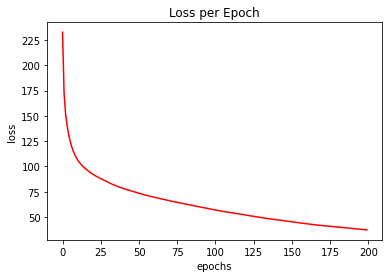

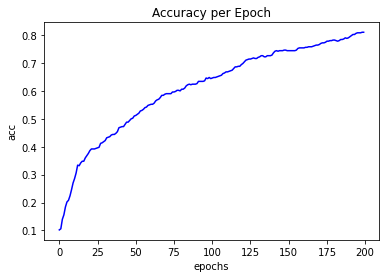

In [ ]:
print("Loss and Accuracy for model 1")
with torch.no_grad():
  loss1, acc1 = entrenar_FFNN(model1, my_dataset, optimizer1, epochs=200, batch_size=10)
plot_results(loss1, acc1)

Loss and Accuracy for model 2


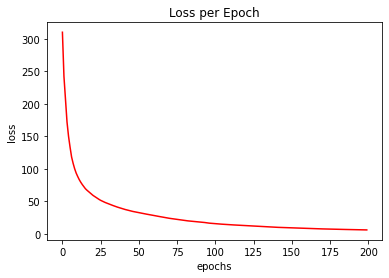

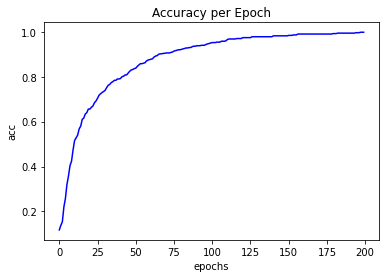

In [ ]:
print("Loss and Accuracy for model 2")
with torch.no_grad():
  loss2, acc2 = entrenar_FFNN(model2, my_dataset, optimizer2, epochs=200, batch_size=10)
plot_results(loss2, acc2)

Loss and Accuracy for model 3


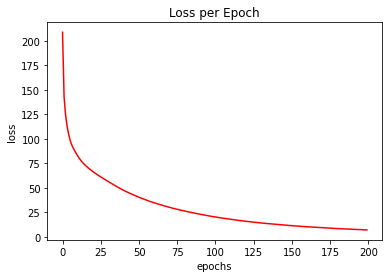

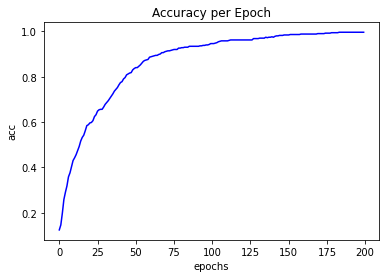

In [ ]:
print("Loss and Accuracy for model 3")
with torch.no_grad():
  loss3, acc3 = entrenar_FFNN(model3, my_dataset, optimizer3, epochs=200, batch_size=10)
plot_results(loss3, acc3)

Loss and Accuracy for model 4


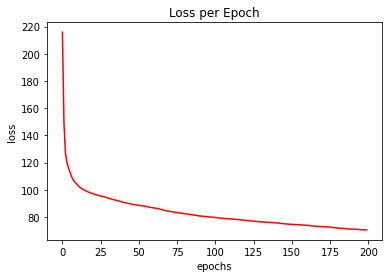

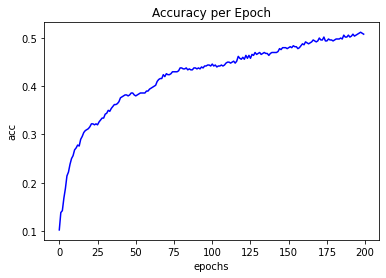

In [ ]:
print("Loss and Accuracy for model 4")
with torch.no_grad():
  loss4, acc4 = entrenar_FFNN(model4, my_dataset, optimizer4, epochs=200, batch_size=10)
plot_results(loss4, acc4)

## 4e) Opcional: Optimizando tu red para MNIST

In [ ]:
# Tu código de carga de datos, creación de la red, 
# entrenamiento/optimización y reportes acá